In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas as pd #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

get_ipython().run_line_magic('matplotlib', 'inline')

# read in overall dataframe
movie_df = pd.read_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/dataframes/movie_df.csv") 

# read in dataframes separated by year
movie_df_2000_2020_n75 = pd.read_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/dataframes/movie_df_2000_2020_n75.csv")
movie_df_2000_2020_n75.head()

,Unnamed: 0,Movie Name,Genre,Year,Country,Text,Tokenized Texts,normalized_tokens,normalized_tokens_count,normalized_tokens_POS,tokenized_sents,normalized_sents,tokenized_words,normalized_words
0,6426624,Sister Mary Explains It All,"Comedy, Drama",2001,English,"@@6426624 ? ( Trademark ) ? Praise my soul , t...","['Trademark', 'Praise', 'my', 'soul', 'the', '...","['trademark', 'praise', 'soul', 'king', 'heave...",3927,"[('@@6426624', 'NNP'), ('?', '.'), ('(', '-LRB...","[['@@6426624'], ['Trademark'], ['Praise', 'my'...","[['@@6426624'], ['trademark'], ['praise', 'sou...","['@@6426624', 'Trademark', 'Praise', 'my', 'so...","['@@6426624', 'trademark', 'praise', 'soul', '..."
1,6766000,ThanksKilling,"Comedy, Horror, Thriller",2009,English,@@6766000 [Birds_chirping] [Screaming] [Scream...,"['Birds_chirping', 'Screaming', 'Screaming_con...","['birds_chirping', 'scream', 'screaming_contin...",2960,"[('@@6766000', 'NNP'), ('[', '-LRB-'), ('birds...","[['@@6766000', 'Birds_chirping'], ['Screaming'...","[['@@6766000', 'birds_chirping'], ['scream'], ...","['@@6766000', 'Birds_chirping', 'Screaming', '...","['@@6766000', 'birds_chirping', 'screaming', '..."
2,4257009,The Brotherhood V: Alumni,"Horror, Thriller",2009,English,@@4257009 Betty ? Betty ? Betty ? Come on . Be...,"['Betty', 'Betty', 'Betty', 'Come', 'on', 'Bet...","['betty', 'betty', 'betty', 'come', 'betty', '...",1687,"[('@@4257009', 'NNP'), ('betty', 'NNP'), ('?',...","[['@@4257009'], ['Betty'], ['Betty'], ['Betty'...","[['@@4257009'], ['betty'], ['betty'], ['betty'...","['@@4257009', 'Betty', 'Betty', 'Betty', 'Come...","['@@4257009', 'betty', 'betty', 'betty', 'come..."
3,5800875,Anton Chekhov's The Duel,Drama,2010,"English, Spanish","@@5800875 Come on . Let wild . Come . Come , c...","['Come', 'on', 'Let', 'wild', 'Come', 'Come', ...","['come', 'let', 'wild', 'come', 'come', 'come'...",1505,"[('@@5800875', 'NNP'), ('come', 'VB'), ('on', ...","[['@@5800875', 'Come', 'on'], ['Let', 'wild'],...","[['@@5800875', 'come'], ['let', 'wild'], ['com...","['@@5800875', 'Come', 'on', 'Let', 'wild', 'Co...","['@@5800875', 'come', 'let', 'wild', 'come', '..."
4,6055372,The Last of Robin Hood,"Biography, Drama, Romance",2013,English,"@@6055372 The world is reeling . Errol Flynn ,...","['The', 'world', 'is', 'reeling', 'Errol', 'Fl...","['world', 'reel', 'errol', 'flynn', 'movie', '...",3339,"[('@@6055372', 'FW'), ('the', 'DT'), ('world',...","[['@@6055372', 'The', 'world', 'is', 'reeling'...","[['@@6055372', 'world', 'reel'], ['errol', 'fl...","['@@6055372', 'The', 'world', 'is', 'reeling',...","['@@6055372', 'world', 'reeling', 'errol', 'fl..."


In [2]:
# # tokenize and normalize text
movie_df_2000_2020_n75['tokenized_sents'] = movie_df_2000_2020_n75['Text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
movie_df_2000_2020_n75['normalized_sents'] = movie_df_2000_2020_n75['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [3]:
# define cooccurrence function
# words that co-occur in the same sentences
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

g_2000_2020 = wordCooccurrence(movie_df_2000_2020_n75['normalized_sents'][:100].sum())

In [4]:
# length of nodes
len(g_2000_2020.nodes)

15606

In [5]:
# length of edges
len(g_2000_2020.edges)

232934

In [6]:
# adjacency matrix of cleaned word by scripts
nx.to_numpy_matrix(g_2000_2020)[:10, :10]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [7]:
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized

import sklearn.feature_extraction
# in case we get a module not found error

In [8]:
movieVectorizer_2000_2020 = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
movieVects_2000_2020_incidence = movieVectorizer_2000_2020.fit_transform(movie_df_2000_2020_n75['Text'][:100])

movieVects_2000_2020_incidence.shape

(75, 15573)

In [9]:
# need to turn the incidence matrix into a network
g_2mode_2000_2020 = nx.Graph()

In [10]:
#define all the nodes
g_2mode_2000_2020.add_nodes_from((movieVectorizer_2000_2020.get_feature_names()[i] for i in range(movieVects_2000_2020_incidence.shape[1])), bipartite = 'word')
g_2mode_2000_2020.add_nodes_from(range(movieVects_2000_2020_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode_2000_2020.add_edges_from(((d, movieVectorizer_2000_2020.get_feature_names()[w], {'weight' : movieVects_2000_2020_incidence[d, w]}) for d, w in zip(*movieVects_2000_2020_incidence.nonzero())))

In [11]:
print(nx.info(g_2mode_2000_2020))

Name: 
Type: Graph
Number of nodes: 15648
Number of edges: 68416
Average degree:   8.7444


/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


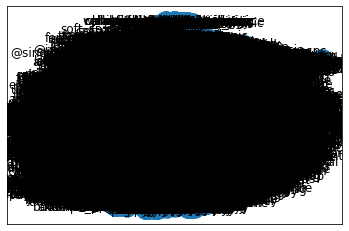

In [12]:
# plot the bipartite network with a quick spring layout
# with no filtering, this will not bring insight 
nx.draw_networkx(g_2mode_2000_2020)

In [13]:
# two-mode network can be easily transformed into two one-mode network, enabling words to be 
# connected to other words via the number of documents that share them, 
# or documents to be connected to other documents via the words they share
def contractNetwork(g_2000_2020, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode_2000_2020.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode_2000_2020.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g_2000_2020.neighbors(n_outside) if g_2000_2020.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [14]:
# document-to-document network:
gDoc_2000_2020 = contractNetwork(g_2mode_2000_2020, 'doc')
print(nx.info(gDoc_2000_2020))

Name: 
Type: Graph
Number of nodes: 75
Number of edges: 2775
Average degree:  74.0000


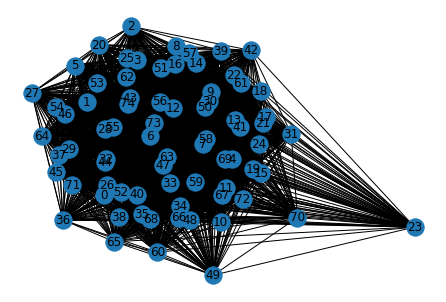

In [15]:
# visualize doc to doc
layout = nx.spring_layout(gDoc_2000_2020, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc_2000_2020, pos = layout, labels = {n:n for n in gDoc_2000_2020.nodes()}) #Getting labels is a bit annoying

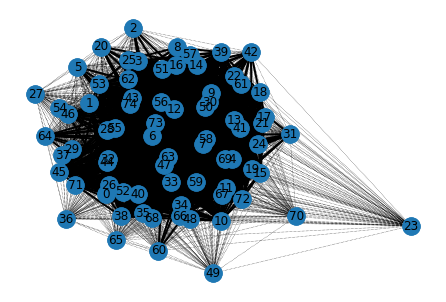

In [16]:
# draw the graph with high and low weight edges distinguished:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc_2000_2020.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc_2000_2020.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc_2000_2020.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc_2000_2020, pos = layout, labels = {n:n for n in gDoc_2000_2020.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc_2000_2020, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

In [17]:
# word-to-word network by documents
gWord_2000_2020 = contractNetwork(g_2mode_2000_2020, 'word')
print(nx.info(gWord_2000_2020))

Name: 
Type: Graph
Number of nodes: 15573
Number of edges: 18848473
Average degree: 2420.6605


In [18]:
# reduce the number of words to a manageable size.
wMean_2000_2020 = np.mean([d['weight'] for n1, n2, d in gWord_2000_2020.edges(data = True)])
wMean_2000_2020

1.9058892463065842

In [19]:
g_2000_2020 = wordCooccurrence(movie_df_2000_2020_n75['normalized_sents'][:100].sum())

In [20]:
len(g_2000_2020)

15606

In [21]:
g_2000_2020.remove_edges_from([(n1, n2) for n1, n2, d in g_2000_2020.edges(data = True) if d['weight'] <= 25])

In [22]:
g_2000_2020.remove_nodes_from(list(nx.isolates(g_2000_2020))) #since we are changing the graph list() evaluates the isolates first

In [23]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

giant_2000_2020 = max(connected_component_subgraphs(g_2000_2020), key=len) # keep just the giant connected component
print(nx.info(giant_2000_2020))

Name: 
Type: Graph
Number of nodes: 116
Number of edges: 421
Average degree:   7.2586


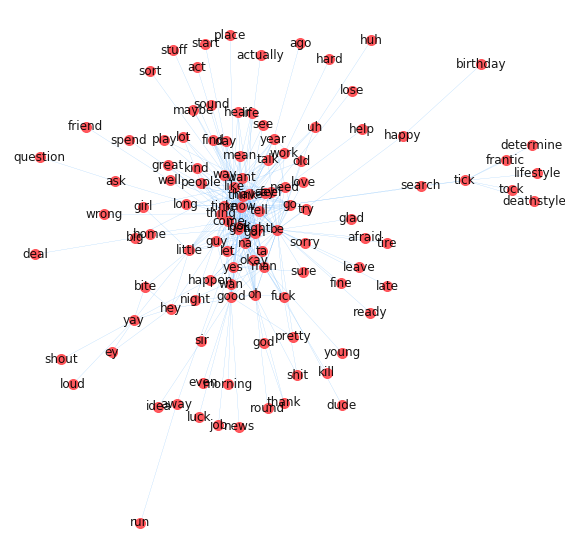

In [24]:
# graph this smaller version
layout = nx.spring_layout(giant_2000_2020, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant_2000_2020, ax = ax, pos = layout, labels = {n:n for n in giant_2000_2020.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [25]:
from networkx.algorithms.community import greedy_modularity_communities
c_2000_2020 = list(greedy_modularity_communities(giant_2000_2020))

In [26]:
# finding communities in graphs
c_2000_2020

[frozenset({'act',
            'actually',
            'afraid',
            'ago',
            'ask',
            'away',
            'be',
            'big',
            'birthday',
            'bite',
            'come',
            'day',
            'deal',
            'deathstyle',
            'determine',
            'dude',
            'even',
            'ey',
            'feel',
            'find',
            'fine',
            'frantic',
            'friend',
            'fuck',
            'get',
            'girl',
            'glad',
            'go',
            'god',
            'gon',
            'good',
            'great',
            'guy',
            'happen',
            'happy',
            'hard',
            'have',
            'hear',
            'help',
            'hey',
            'home',
            'huh',
            'idea',
            'job',
            'kill',
            'kind',
            'know',
            'late',
            'leave',
       

In [27]:
# can also remove those words that show up in many documents
giant_2000_2020 = nx.Graph(giant_2000_2020)

In [28]:
giant_2000_2020.remove_nodes_from([n for n in giant_2000_2020.nodes if len(set(giant_2000_2020.neighbors(n))) >= 2000]) 
giant_2000_2020.remove_nodes_from(list(nx.isolates(giant_2000_2020)))
print(nx.info(giant_2000_2020))

Name: 
Type: Graph
Number of nodes: 116
Number of edges: 421
Average degree:   7.2586


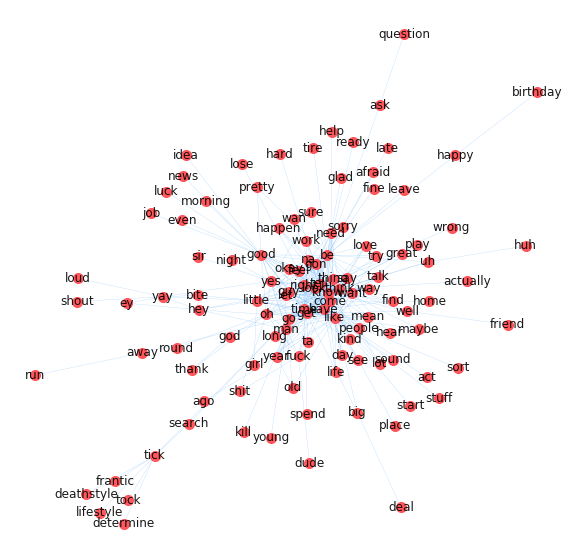

In [29]:
layout = nx.spring_layout(giant_2000_2020, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant_2000_2020, ax = ax, pos = layout, labels = {n:n for n in giant_2000_2020.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [30]:
# find cliques, or completely connected sets of nodes.
print(', '.join(max(nx.clique.find_cliques(giant_2000_2020), key = lambda x: len(x))))

like, know, be, get, right, thing, go, think, want, come, have


In [31]:
# look at a subgraph of the network, those nodes that are within 1 or 2 network steps of 'afraid'.
gunNeighbors = giant_2000_2020.neighbors('afraid')
g_gun = giant_2000_2020.subgraph(gunNeighbors)

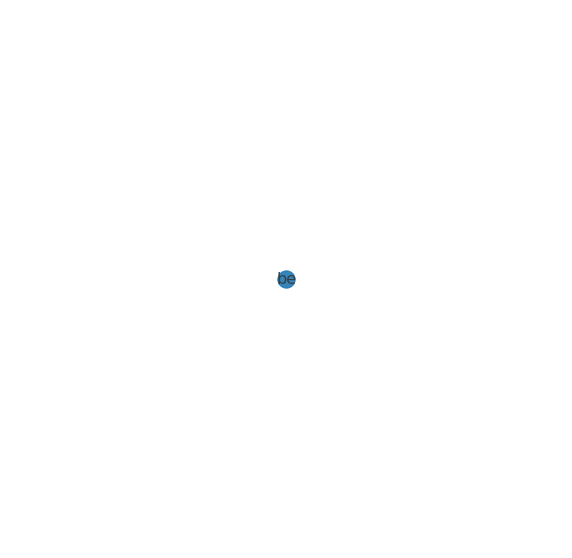

In [32]:
layout_gun = nx.spring_layout(g_gun, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_gun.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_gun.edges(data = True)))
nx.draw(g_gun, ax = ax, pos = layout_gun, labels = {n:n for n in g_gun.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_gun.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

In [33]:
gunNeighbors = gWord_2000_2020.neighbors('afraid')
gunNeighborsPlus1 = set(gunNeighbors)
for n in gunNeighbors:
    gunNeighborsPlus1 |= set(giant_2000_2020.neighbors(n))

In [34]:
g_gun2 = giant_2000_2020.subgraph(gunNeighborsPlus1)
print(nx.info(g_gun2))

Name: 
Type: Graph
Number of nodes: 115
Number of edges: 420
Average degree:   7.3043


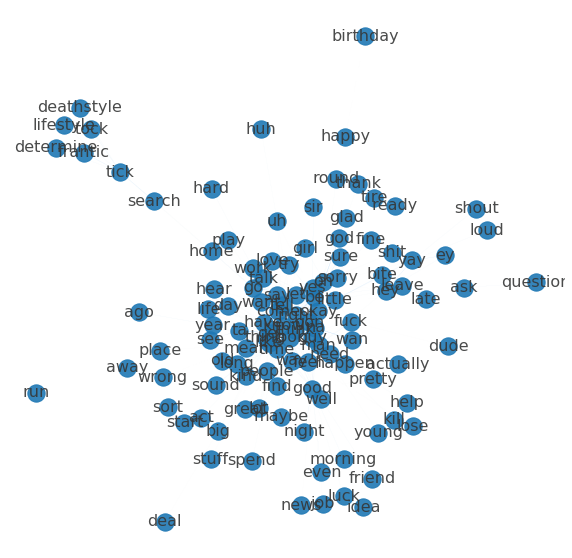

In [35]:
layout_gun = nx.spring_layout(g_gun2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_gun = nx.eigenvector_centrality(g_gun2)
maxC = max(centralities_gun.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_gun2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_gun2.edges(data = True)))
nx.draw(g_gun2, ax = ax, pos = layout_gun, labels = {n:n for n in g_gun2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_gun2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

In [36]:
# can often gain more insight into our semantic network through statistics that describe the positions of words within it.
dcentralities_2000_2020 = nx.degree_centrality(giant_2000_2020)

In [38]:
dcentralities_2000_2020['afraid']

0.008695652173913044

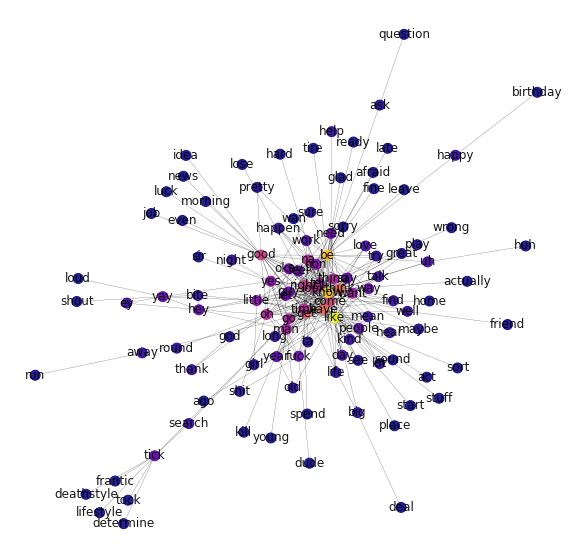

In [39]:
# We can color and size the nodes by betweenness centrality,
max(dcentralities_2000_2020.items(), key = lambda x : x[1])

fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities_2000_2020.items(), key = lambda x : x[1])[1]
nx.draw(giant_2000_2020, ax = ax, pos = layout, labels = {n:n for n in giant_2000_2020.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities_2000_2020[n] / maxC for n in giant_2000_2020.nodes],
        cmap = plt.get_cmap('plasma'))

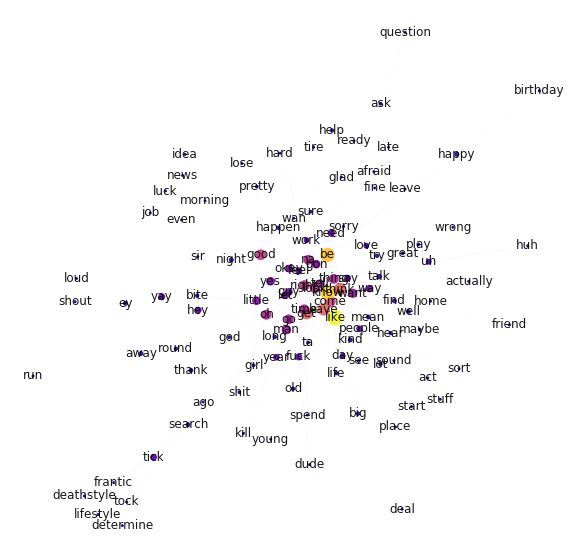

In [40]:
# use of size to represent degree centrality and edge weight:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities_2000_2020.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_2000_2020.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_2000_2020.edges(data = True)))
nx.draw(giant_2000_2020, ax = ax, pos = layout, labels = {n:n for n in giant_2000_2020.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord_2000_2020.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities_2000_2020[n] / maxC for n in giant_2000_2020.nodes],
        node_size = [dcentralities_2000_2020[n] / maxC * 200 for n in giant_2000_2020.nodes],
        cmap = plt.get_cmap('plasma'))

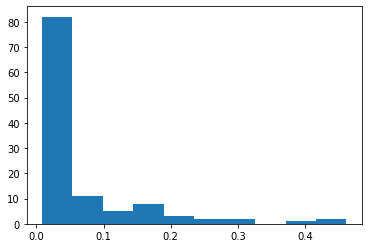

In [41]:
# The distrubution of degree centrality is:
plt.hist(list(dcentralities_2000_2020.values()))
plt.show()

In [42]:
# top words by degree
sorted(dcentralities_2000_2020.items(), key = lambda x: x[1], reverse = True)[:10]

[('like', 0.4608695652173913),
 ('know', 0.4173913043478261),
 ('be', 0.4),
 ('think', 0.28695652173913044),
 ('have', 0.28695652173913044),
 ('get', 0.2782608695652174),
 ('come', 0.23478260869565218),
 ('good', 0.21739130434782608),
 ('right', 0.20869565217391306),
 ('look', 0.2)]

In [43]:
# different measure, which is betweenness centrality. 
# Betweenness centrality distinguishes nodes that require the most shortest pathways between
# all other nodes in the network. Semantically, words with a high betweenness centrality may link 
# distinctive domains, rather than being "central" to any one. 
# In other words, high betweenness centrality nodes may not have the highest degree centrality.
centralities_2000_2020 = nx.betweenness.betweenness_centrality(giant_2000_2020)
centralities_2000_2020['afraid']

0.0

In [44]:
max(centralities_2000_2020.items(), key = lambda x : x[1])

('be', 0.25808737856348707)

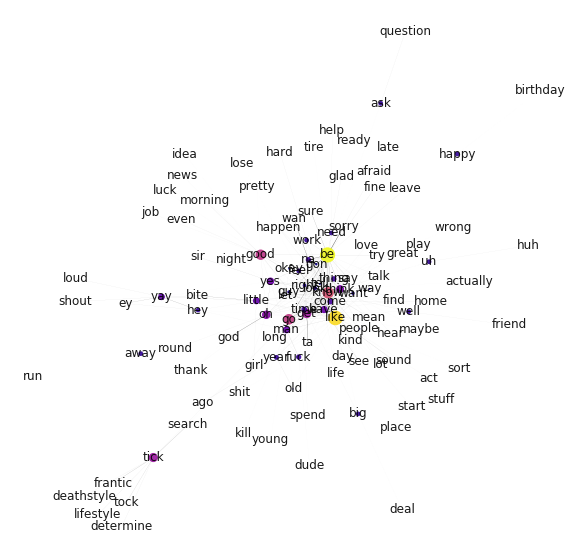

In [45]:
# color and size the nodes by betweenness centrality:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities_2000_2020.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_2000_2020.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_2000_2020.edges(data = True)))
nx.draw(giant_2000_2020, ax = ax, pos = layout, labels = {n:n for n in giant_2000_2020.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant_2000_2020.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_2000_2020[n] / maxC for n in giant_2000_2020.nodes],
        node_size = [centralities_2000_2020[n] / maxC * 200 for n in giant_2000_2020.nodes],
        cmap = plt.get_cmap('plasma'))

In [46]:
# What are the top ten words in terms of betweenness? 
sorted(dcentralities_2000_2020.items(), key = lambda x: x[1], reverse = True)[:10]

[('like', 0.4608695652173913),
 ('know', 0.4173913043478261),
 ('be', 0.4),
 ('think', 0.28695652173913044),
 ('have', 0.28695652173913044),
 ('get', 0.2782608695652174),
 ('come', 0.23478260869565218),
 ('good', 0.21739130434782608),
 ('right', 0.20869565217391306),
 ('look', 0.2)]

In [47]:
# closeness centrality, or the average Euclidean or path distance between a node and all others in the network.
# A node with the highest closeness centrality is most likely to send a signal with the most coverage to the 
# rest of the network.
centralities_2000_2020 = nx.closeness_centrality(giant_2000_2020)

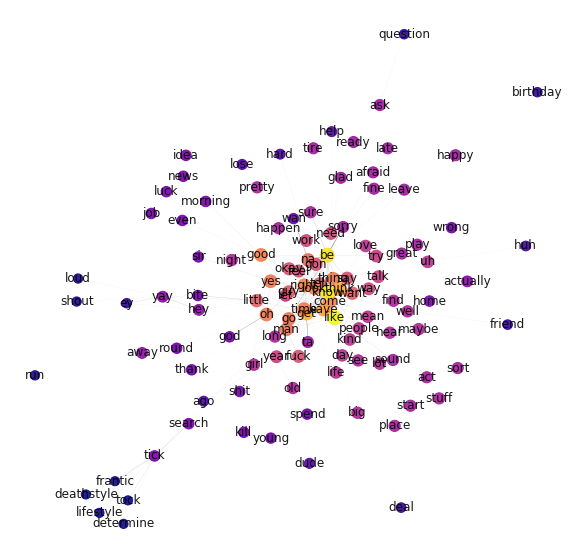

In [48]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities_2000_2020.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_2000_2020.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_2000_2020.edges(data = True)))
nx.draw(giant_2000_2020, ax = ax, pos = layout, labels = {n:n for n in giant_2000_2020.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant_2000_2020.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_2000_2020[n] / maxC for n in giant_2000_2020.nodes],
        node_size = [centralities_2000_2020[n] / maxC * 200 for n in giant_2000_2020.nodes],
        cmap = plt.get_cmap('plasma'))

In [49]:
# Top:
sorted(centralities_2000_2020.items(), key = lambda x: x[1], reverse = True)[:10]

[('like', 0.5989583333333334),
 ('know', 0.5867346938775511),
 ('be', 0.5808080808080808),
 ('get', 0.539906103286385),
 ('think', 0.5299539170506913),
 ('have', 0.5227272727272727),
 ('come', 0.49783549783549785),
 ('right', 0.4956896551724138),
 ('good', 0.49145299145299143),
 ('look', 0.49145299145299143)]

In [50]:
# Or eignvector centrality, an approach that weights degree by the centrality of those to whom 
# one is tied (and the degree to whom they are tied, etc.) 
# In short, its an $n$th order degree measure.
centralities_2000_2020 = nx.eigenvector_centrality(giant_2000_2020)

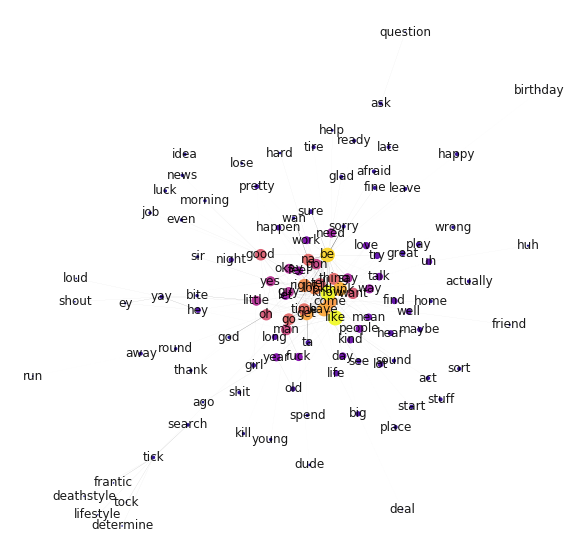

In [51]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities_2000_2020.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_2000_2020.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_2000_2020.edges(data = True)))
nx.draw(giant_2000_2020, ax = ax, pos = layout, labels = {n:n for n in giant_2000_2020.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant_2000_2020.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_2000_2020[n] / maxC for n in giant_2000_2020.nodes],
        node_size = [centralities_2000_2020[n] / maxC * 200 for n in giant_2000_2020.nodes],
        cmap = plt.get_cmap('plasma'))

In [52]:
# top
sorted(centralities_2000_2020.items(), key = lambda x: x[1], reverse = True)[:10]

[('know', 0.2967984044784486),
 ('like', 0.2956922362970593),
 ('be', 0.271470940624375),
 ('think', 0.24373813605583122),
 ('have', 0.23701654279314116),
 ('get', 0.23407454264204966),
 ('come', 0.22496031373512623),
 ('right', 0.2145499751103258),
 ('look', 0.20672919113018778),
 ('time', 0.18212325884867758)]

In [53]:
import spacy
nlp = spacy.load('en')

In [54]:
# look at POS based networks
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [55]:
gNN_2000_2020 = posCooccurrence(movie_df_2000_2020_n75['normalized_sents'].sum(), 'NN')

In [56]:
print(nx.info(gNN_2000_2020))

Name: 
Type: Graph
Number of nodes: 5721
Number of edges: 32486
Average degree:  11.3568


In [57]:
# # this is a bit too large to effectively visualize, so let's remove the vertices with degree less than or equal to 100:
gNN_2000_2020.remove_nodes_from([n for n in gNN_2000_2020.nodes if len(set(gNN_2000_2020.neighbors(n))) <= 100]) 
print(nx.info(gNN_2000_2020))

Name: 
Type: Graph
Number of nodes: 99
Number of edges: 2089
Average degree:  42.2020


In [58]:
# and edges low weight
gNN_2000_2020.remove_edges_from([(n1, n2) for n1, n2, d in gNN_2000_2020.edges(data = True) if d['weight'] <= 2])
print(nx.info(gNN_2000_2020))

Name: 
Type: Graph
Number of nodes: 99
Number of edges: 533
Average degree:  10.7677


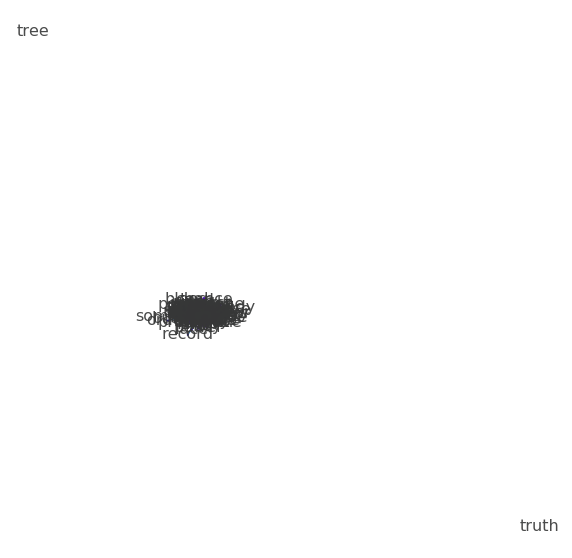

In [59]:
# visualize
layout_nn = nx.spring_layout(gNN_2000_2020, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN_2000_2020)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN_2000_2020.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN_2000_2020.edges(data = True)))
nx.draw(gNN_2000_2020, ax = ax, pos = layout_nn, labels = {n: n for n in gNN_2000_2020.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN_2000_2020.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN_2000_2020.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [60]:
# # What if we want to look at noun-verb pairs instead?
gNV_2000_2020 = posCooccurrence(movie_df_2000_2020_n75['normalized_sents'].sum(), 'NN', 'VB')

In [61]:
# gNV has co-occurrences between nouns and nouns as well as between verbs and verbs. Let's remove these and make it purely about noun and verb combinations:
print(nx.info(gNV_2000_2020))

Name: 
Type: Graph
Number of nodes: 6054
Number of edges: 55030
Average degree:  18.1797


In [62]:
gNV_2000_2020.remove_edges_from([(n1,n2) for n1,n2,d in gNV_2000_2020.edges(data = True) if gNV_2000_2020.nodes[n1]['bipartite'] == gNV_2000_2020.nodes[n2]['bipartite']])

In [63]:
print(nx.info(gNV_2000_2020))

Name: 
Type: Graph
Number of nodes: 6054
Number of edges: 21566
Average degree:   7.1245


In [64]:
# Dropping low weight edges and low degree vertices gives us:
gNV_2000_2020.remove_edges_from([(n1, n2) for n1, n2, d in gNV_2000_2020.edges(data = True) if d['weight'] <= 2])
gNV_2000_2020.remove_nodes_from([n for n in gNV_2000_2020.nodes if len(set(gNV_2000_2020.neighbors(n))) <= 5])

In [65]:
print(nx.info(gNV_2000_2020))

Name: 
Type: Graph
Number of nodes: 162
Number of edges: 1176
Average degree:  14.5185


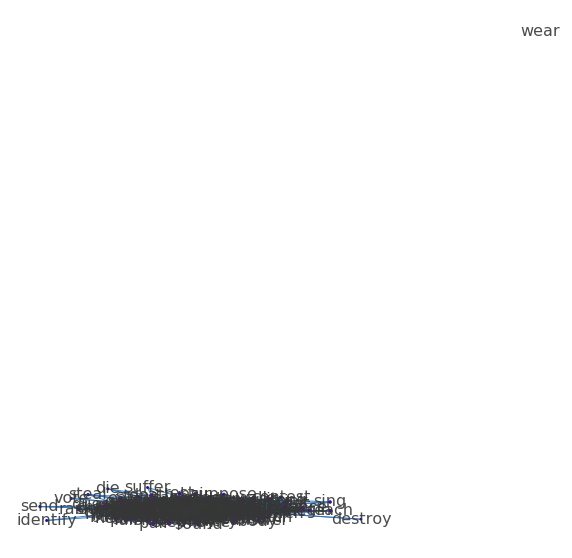

In [66]:
layout_nn = nx.spring_layout(gNV_2000_2020, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV_2000_2020,max_iter=500)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV_2000_2020.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV_2000_2020.edges(data = True)))
nx.draw(gNV_2000_2020, ax = ax, pos = layout_nn, labels = {n: n for n in gNV_2000_2020.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV_2000_2020.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV_2000_2020.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [67]:
# create an "ego network" surrounding a single (important) word, as we did before:
g_i_2000_2020 = gNV_2000_2020.subgraph(['die'] + list(gNV_2000_2020.neighbors('die')))

In [68]:
print(nx.info(g_i_2000_2020))

Name: 
Type: Graph
Number of nodes: 4
Number of edges: 3
Average degree:   1.5000


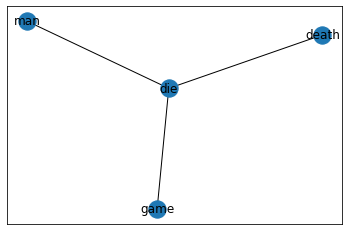

In [69]:
nx.draw_networkx(g_i_2000_2020)

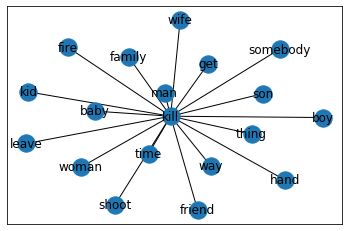

In [74]:
g_i_2000_2020 = gNV_2000_2020.subgraph(['kill'] + list(gNV_2000_2020.neighbors('kill')))
nx.draw_networkx(g_i_2000_2020)

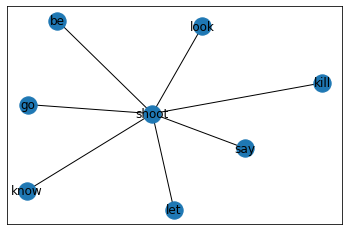

In [75]:
g_i_2000_2020 = gNV_2000_2020.subgraph(['shoot'] + list(gNV_2000_2020.neighbors('shoot')))
nx.draw_networkx(g_i_2000_2020)

In [70]:
gNJ_2000_2020 = posCooccurrence(movie_df_2000_2020_n75['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ_2000_2020))

Name: 
Type: Graph
Number of nodes: 7496
Number of edges: 57995
Average degree:  15.4736


In [71]:
# can now filter our network by a centrality measure. Let's define a function and experiment with it:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [72]:
gNJ_filtered200_2000_2020 = filterWords(gNJ_2000_2020, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200_2000_2020))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 171
Average degree:  13.6800


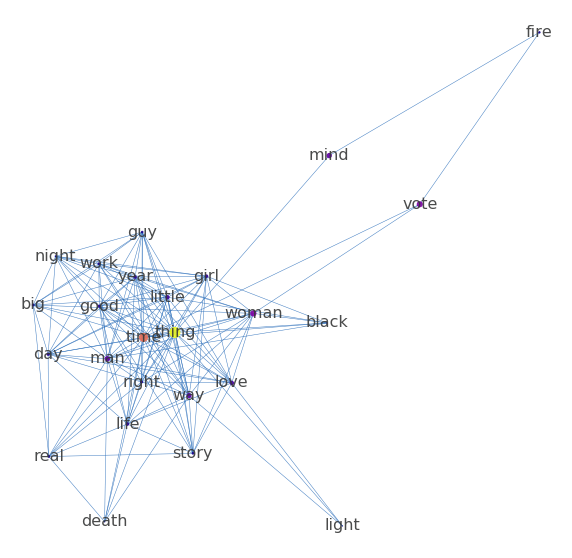

In [73]:
# visualize
layout_NJ_filtered200_2000_2020 = nx.spring_layout(gNJ_filtered200_2000_2020, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200_2000_2020)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200_2000_2020, ax = ax, pos = layout_NJ_filtered200_2000_2020, labels = {n: n for n in gNJ_filtered200_2000_2020.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200_2000_2020.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200_2000_2020.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )